In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

In [8]:
device = 'cuda'
batch_size = 64
num_workers = 4
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
epoch = 20
n_steps = 10000

In [26]:
from torch.utils.data import DataLoader, RandomSampler

# Data transformation of train and test data
data_transforms = {
    'train': transforms.Compose([
        # build your own transforms
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(128),
        transforms.RandomRotation(0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}

train_dataset = datasets.ImageFolder('Linnaeus 5 128X128/train', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder('Linnaeus 5 128X128/test', transform=data_transforms['test'])

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
print(len(test_dataset))

3600
1200


Size of train set: 3600
Input shape: torch.Size([3, 128, 128])
Label: 2


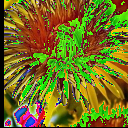

In [30]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_dataset)}")
index = 2400
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [32]:
# Minimal MLP implementation
# DO NOT CHANGE Model name

class block(nn.Module):
    def __init__(self, dim_1, dim_2, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(dim_1, dim_2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(dim_2)
        self.conv2 = nn.Conv2d(dim_2, dim_2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(dim_2)

        self.shortcut = nn.Sequential()
        if stride != 1 or dim_1 != dim_2:
            self.shortcut = nn.Sequential(
                nn.Conv2d(dim_1, dim_2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim_2)
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)  



    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Model(nn.Module):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        self.in_dim = 128

        self.conv1 = nn.Conv2d(3, self.in_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_dim)
        self.layer1 = self._make_layer(32*2, 2, stride=1)
        self.layer2 = self._make_layer(32*4, 2, stride=2)
        self.layer3 = self._make_layer(32*8, 2, stride=2)
        self.layer4 = self._make_layer(32*8, 2, stride=2)
        self.layer5 = self._make_layer(32*16, 2, stride=2)

        self.clf = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), 
                                        nn.Flatten(), 
                                        nn.Linear(32*16, num_classes),
                                        nn.LogSoftmax(dim=-1))

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_dim, planes, stride))
            self.in_dim = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.clf(out)

        return out

In [33]:
Model()

Model(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [35]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
model = Model()
early_stopping = EarlyStopping(patience=5, verbose=True)
best_model = None
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
model = model.to(device)

for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # Summary & Eval
    if step % 500 == 0:
        
        total, correct = 0, 0
        test_loss = 0
        model.eval()
        for x, y in tqdm(test_dataloader, leave=False):
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}, test_loss: {test_loss:.2f}, test_accuracy: {accuracy:.4f}")

        best_model = early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
model = best_model

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[Step 500] train_loss: 0.50, test_loss: 0.46, test_accuracy: 0.7900
Validation loss decreased (inf --> 0.462823).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 1000] train_loss: 0.30, test_loss: 0.36, test_accuracy: 0.8658
Validation loss decreased (0.462823 --> 0.363695).


In [3]:
def divide_image(image):
    sub_blocks = []
    sub_block_height = 40
    sub_block_width = 40
    
    s_p = [0, 44, 88]
    
    for s_i in s_p:
        for s_j in s_p:
            start_x = s_j
            start_y = s_i
            end_x = start_x + sub_block_width
            end_y = start_y + sub_block_height
            sub_block = image[start_y:end_y, start_x:end_x, :]
            sub_blocks.append(sub_block)
    return sub_blocks

In [4]:
data = []
labels = []
div_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/train/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/train/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_data.append(divide_image(image=img_arr))
        data.append(img_arr)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

['dog', 'bird', 'flower']


In [4]:
## test
test_data = []
test_labels = []
div_test_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/test/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/test/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_test_data.append(divide_image(image=img_arr))
        test_data.append(img_arr)
        test_labels.append(i)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

['dog', 'bird', 'flower']


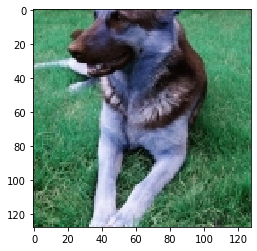

In [5]:
plt.imshow(test_data[0])

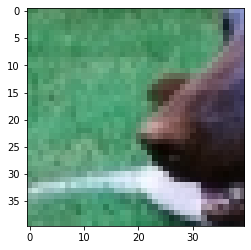

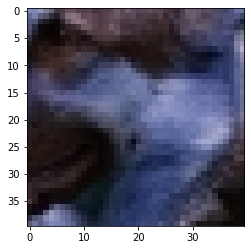

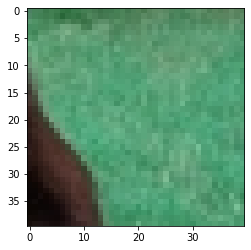

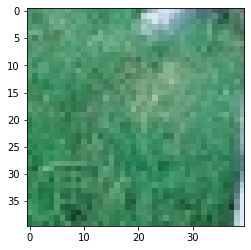

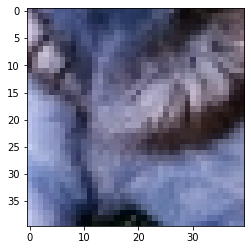

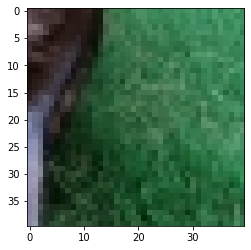

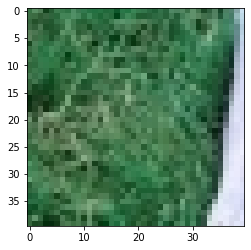

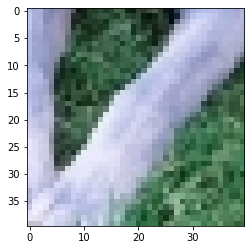

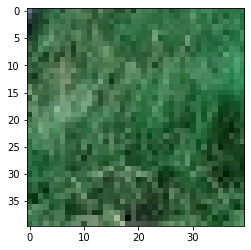

In [6]:
for im in np.array(div_test_data[0]):
    plt.figure()
    plt.imshow(im)


In [7]:
def reconstruct_image(combined_blocks):
    rows = []
    for i in range(0, 18, 3):
        row = np.concatenate(combined_blocks[i:i+3], axis=0)
        rows.append(row)
    merged_image = np.concatenate(rows, axis=1)
    return merged_image

def shuffle_blocks(blocks_a, blocks_b):
    shf_blocks = []
    for b_a, b_b in zip(blocks_a, blocks_b):
        random.shuffle(b_a)
        random.shuffle(b_b)
    
        mixed_sub_block = b_a + b_b
        random.shuffle(mixed_sub_block)
        shf_blocks.append(reconstruct_image(mixed_sub_block))
    return shf_blocks

In [8]:
def mk_shuffle_data(divided_data, d_size):
    
    label_idx = [0, d_size*1, d_size*2] 
    shf_labels = []
    shf_datas = []
    for i, l_i in enumerate(label_idx):
        class1 = divided_data[l_i : l_i+d_size]

        for j, l_i2 in enumerate(label_idx[i+1:]):
            if l_i == l_i2:
                continue
            class2 = divided_data[l_i2: l_i2+d_size]

            labels_list = [[l_i//d_size, l_i2//d_size]]* d_size
            shf_labels.append(labels_list)
            shf_datas.append(shuffle_blocks(class1, class2))
    return shf_datas, shf_labels

In [9]:
target_shf_datas, target_shf_labels = mk_shuffle_data(divided_data=div_test_data, d_size=test_data.shape[0]//3)

In [10]:
np.array(target_shf_datas).shape

(3, 400, 120, 240, 3)

In [11]:
shf_target_arr = np.array(target_shf_datas).reshape(-1,120, 240,3)

shf_target_arr.shape

(1200, 120, 240, 3)

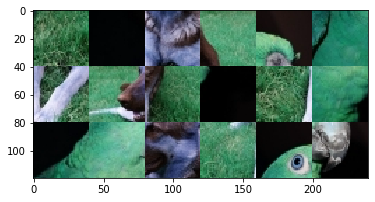

In [12]:
plt.imshow(shf_target_arr[0])

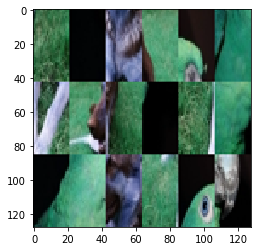

In [13]:

image_from_array = Image.fromarray(shf_target_arr[0], 'RGB')
resized_image = image_from_array.resize((128, 128))

plt.imshow(np.array(resized_image))

In [14]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

In [15]:


def build_model():
    model = Sequential([
        Conv2D(64, (3,3), padding='same', activation="relu", input_shape=(height, width, 3)),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((2, 2)),
        
        Conv2D(256, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D((2, 2)),
        
        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D((2, 2)),
        
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax")])
    
    return model


def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (height, width, 3), classes = 3):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(classes, activation = 'softmax')(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50CL")
    
    return model


In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [17]:
x = data.astype('float32')
y = labels

# class_weights = dict(zip(np.unique(labels),
#                          compute_class_weight(class_weight = "balanced", classes=np.unique(labels), y = labels)))

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, shuffle=True, random_state=0)

x_train = x_train / 255.
x_val = x_val / 255.

# y_val = to_categorical(np.array(y_val))
# y_train = to_categorical(np.array(y_train))

model1 = ResNet50()

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)

rlr_call = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=4, verbose=1)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model1.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

with tf.device("/device:GPU:0"):
    history = model1.fit(x_train, y_train, epochs=200, batch_size=64, 
                        validation_data=(x_val, y_val),
                        callbacks=[rlr_call,EarlyStopping(monitor="val_loss", patience=10)])
    
#     history = model1.fit(x_train, y_train, epochs=200, batch_size=64, 
#                         validation_data=(x_val, y_val),
#                         callbacks=[rlr_call,EarlyStopping(monitor="val_loss", patience=10)],
#                         class_weight=class_weights)
    
    model1.save('resnet.h5')

Train on 2880 samples, validate on 720 samples
Epoch 1/200
2880/2880 [==============================] - 265s 92ms/sample - loss: 1.1034 - acc: 0.3358 - val_loss: 1.0988 - val_acc: 0.3139
Epoch 2/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0990 - val_acc: 0.3139
Epoch 3/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0991 - val_acc: 0.3139
Epoch 4/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0991 - val_acc: 0.3139
Epoch 5/200
2816/2880 [============================>.] - ETA: 0s - loss: 1.0986 - acc: 0.3388
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0992 - val_acc: 0.3139
Epoch 6/200
2880/2880 [==============================] - 41s 14ms/sample - loss: 1.0985 - acc: